In [55]:
import pickle
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import natsort
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import MDS

import analysis
import datasets


def show_best_dim_cors(groupCoordinates, modelInfo, modelNames):
    numericalCols = [
        "Parameters",
        "Layers",
        "Residual Blocks",
        "Conv Layers",
        "Dense Layers",
        "Bottlenecks",
        "Pooling Layers",
        "Normalization Layers",
        "Recurrent Layers",
        "Attention Layers",
        "Output Features",
        "First Layer Parameters",
        "Highest Internal Layer Parameters",
        "Lowest Internal Layer Parameters",
        "Last Layer Parameters",
    ]

    # Loop through dimensions of gspace
    dimDict = {}
    for i in range(groupCoordinates.shape[1]):
        print(f"Dimension {i + 1}")

        dimDict[i] = {}

        # Loop through numericalCols
        for col in numericalCols:
            coords = np.array([])
            values = np.array([])

            for j, model in enumerate(modelNames):
                if (
                    model in modelInfo["Model"].values
                    and not pd.isna(
                        modelInfo.loc[modelInfo["Model"] == model, col].values[0]
                    )
                    and modelInfo.loc[modelInfo["Model"] == model, col].values[0] != 0
                ):
                    coords = np.append(coords, groupCoordinates[j, i])
                    values = np.append(
                        values, modelInfo[modelInfo["Model"] == model][col].values[0]
                    )

            # Get correlation if there's enough values
            if len(values) < 500:
                print(f"Only have {len(values)} values for {col} and dim {i}")
                continue

            correlation = np.corrcoef(coords, values)[0, 1]
            # print(
            #     f"Correlation between {col} and dim {i}: r({len(values)}) = {correlation}"
            # )

            dimDict[i][col] = {
                "values": values,
                "coords": coords,
                "cor": correlation,
            }

        cors = [
            (idx, abs(dimDict[i][col]["cor"]))
            for idx, col in enumerate(dimDict[i].keys())
        ]
        cors = sorted(cors, key=lambda x: x[1], reverse=True)
        # Print out sorted correlations
        print("Sorted correlations:")
        for idx, cor in cors:
            print(f"{list(dimDict[i].keys())[idx]}: {cor}")

        print("==")

    return dimDict


def plot_mds(
    ax, coordinates, modelInfo, modelNames, dim1, dim2, sizeCol, colorCol, showName
):
    # Make a color scale
    colorMin = modelInfo[colorCol].min()
    colorMax = modelInfo[colorCol].max()
    colorNorm = matplotlib.colors.Normalize(vmin=colorMin, vmax=colorMax)
    colorMapper = matplotlib.cm.ScalarMappable(norm=colorNorm, cmap=matplotlib.cm.cool)

    # Make a size scale
    sizeMin = modelInfo[sizeCol].min()
    sizeMax = modelInfo[sizeCol].max()
    sizeNorm = matplotlib.colors.Normalize(vmin=sizeMin, vmax=sizeMax)
    minSize = 30
    maxSize = 1000

    for i, modelName in enumerate(modelNames):
        x = coordinates[i, dim1]
        y = coordinates[i, dim2]

        # Find the row in modelInfo
        row = modelInfo[modelInfo["Model"] == modelName]
        if row.empty:
            # Make the marker an x
            size = minSize
            marker = "x"
            color = "black"
        else:
            # Check if columns are NaN
            if pd.isna(row[colorCol].values[0]):
                color = "black"
            else:
                value = row[colorCol].values[0]
                color = colorMapper.to_rgba(value) if value > 0 else "gray"

            if pd.isna(row[sizeCol].values[0]):
                size = minSize
                marker = "x"
            else:
                value = row[sizeCol].values[0]
                size = minSize + (maxSize - minSize) * sizeNorm(value)
                marker = "o" if value > 0 else "s"

        ax.scatter(x, y, s=size, marker=marker, color=color, alpha=1, edgecolor="black")

        if showName:
            ax.text(x, y, modelName)

    # Label axes
    ax.set_xlabel(f"Dim {dim1+1}")
    ax.set_ylabel(f"Dim {dim2+1}")

    # Add annotation for color and size
    ax.text(
        0.99,
        0.01,
        f"Color: {colorCol}",
        verticalalignment="bottom",
        horizontalalignment="right",
        transform=ax.transAxes,
    )
    ax.text(
        0.99,
        0.03,
        f"Size: {sizeCol}",
        verticalalignment="bottom",
        horizontalalignment="right",
        transform=ax.transAxes,
    )


def plot_all_mds(coordinates, modelInfo, modelNames, dimCols, showName):
    # Check how many dimensions we have
    numDims = coordinates.shape[1]

    # Loop through dimensions, 2 at a time
    for i in range(int(np.ceil(numDims / 2))):
        # Make a figure
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))

        # Get the dimensions to plot
        dim1 = i * 2
        dim2 = i * 2 + 1

        # Last plot so duplicate a dimension
        if dim2 >= numDims:
            dim2 = dim1
            dim1 = (i - 1) * 2

        plot_mds(
            ax,
            coordinates,
            modelInfo,
            modelNames,
            dim1,
            dim2,
            dimCols[dim1],
            dimCols[dim2],
            showName,
        )

        fig.show()


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [2]:
indscalFiles = os.listdir("../data_storage/indscal")
indscalFiles = natsort.natsorted(indscalFiles)

# Load indscal results
indscalResults = []
for file in indscalFiles:
    with open("../data_storage/indscal/" + file, "rb") as f:
        results = pickle.load(f)

        # Add n dims basd on file name
        results["nDims"] = int(file.split("_")[1].replace("d", ""))

        indscalResults.append(results)

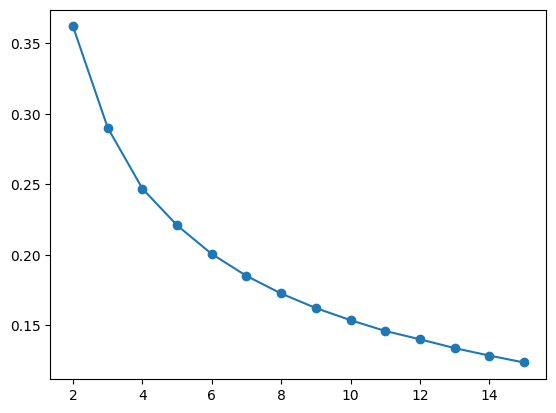

In [3]:
# Plot stress elbow plot
indscalStress = [result["stress"] for result in indscalResults]
nDims = [result["nDims"] for result in indscalResults]
plt.plot(nDims, indscalStress, marker="o")

In [120]:
firstFile = list(datasets._DATA_DIRS.keys())[0]

# Load the first dataset to get info
data = pd.read_csv(f"../data_storage/sims/{firstFile}.csv", index_col=0)
modelNames = data.columns

modelInfoFiles = [
    "models_summary_keras.csv",
    "models_summary_tfhub.csv",
    "models_summary_pytorch.csv",
    "models_summary_timm_new.csv",
]

# Load each file and concatenate
modelInfo = pd.concat(
    [pd.read_csv(f"../data_storage/modelData/{file}") for file in modelInfoFiles]
)

# Load family data and left join
familyData = pd.read_csv("../data_storage/modelData/family_data.csv")
hasColumns = [
    "Convolutional Layers",
    "Residual Blocks",
    "Dense Layers",
    "Bottlenecks",
    "Recurrent Layers",
    "Skip Connections",
    "Attention Layers",
    "ReLU",
    "GeLU",
]
# Add "has" in front of has columns
familyData = familyData.rename(columns={col: "has " + col for col in hasColumns})

# Rename other relevant columns
familyData = familyData.rename(columns={"Pooling": "Pooling Type"})

# Left join
modelInfo = modelInfo.merge(familyData, on="Family")

# Scale down parameters to be in the millions
modelInfo["Parameters"] = modelInfo["Parameters"] / 1_000_000

# Scale down layers by 10
modelInfo["Layers"] = modelInfo["Layers"] / 10

modelInfo.columns

Index(['Model', 'Parameters', 'Layers', 'Residual Blocks', 'Conv Layers',
       'Dense Layers', 'Bottlenecks', 'Pooling Layers', 'Normalization Layers',
       'Recurrent Layers', 'Attention Layers', 'Output Features',
       'Training Dataset', 'RF25 Layer Number', 'RF25 Layer Name', 'Max RF',
       'Family', 'MAX RF', 'Architecture', 'Crop Percentage',
       'First Layer Parameters', 'Highest Internal Layer Parameters',
       'Lowest Internal Layer Parameters', 'Last Layer Parameters',
       'has Convolutional Layers', 'has Residual Blocks', 'has Dense Layers',
       'has Bottlenecks', 'has Recurrent Layers', 'has Skip Connections',
       'has Attention Layers', 'Tokenized', 'Transformer', 'has ReLU',
       'has GeLU', 'Other', 'Year Made', 'Learning Type',
       'Primary Application', 'Key Distinguishing Feature', 'Pooling Type'],
      dtype='object')

In [5]:
groupCoordinates = indscalResults[0]["gspace"]
_ = show_best_dim_cors(groupCoordinates, modelInfo, modelNames)

Dimension 1
Only have 153 values for Residual Blocks and dim 0
Only have 197 values for Bottlenecks and dim 0
Only have 239 values for Pooling Layers and dim 0
Only have 0 values for Recurrent Layers and dim 0
Only have 236 values for Attention Layers and dim 0
Sorted correlations:
Layers: 0.34510956567763124
Dense Layers: 0.33863976222978065
Highest Internal Layer Parameters: 0.19022865558810084
Parameters: 0.18797621296613626
Normalization Layers: 0.1491709551011655
First Layer Parameters: 0.12045066512364691
Conv Layers: 0.1119795259876084
Last Layer Parameters: 0.10070000323630018
Output Features: 0.08184595092177796
Lowest Internal Layer Parameters: 0.006307615339353208
==
Dimension 2
Only have 153 values for Residual Blocks and dim 1
Only have 197 values for Bottlenecks and dim 1
Only have 239 values for Pooling Layers and dim 1
Only have 0 values for Recurrent Layers and dim 1
Only have 236 values for Attention Layers and dim 1
Sorted correlations:
Highest Internal Layer Paramet

/tmp/ipykernel_970482/3086515401.py:133: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, s=size, marker=marker, color=color, alpha=1, edgecolor="black")


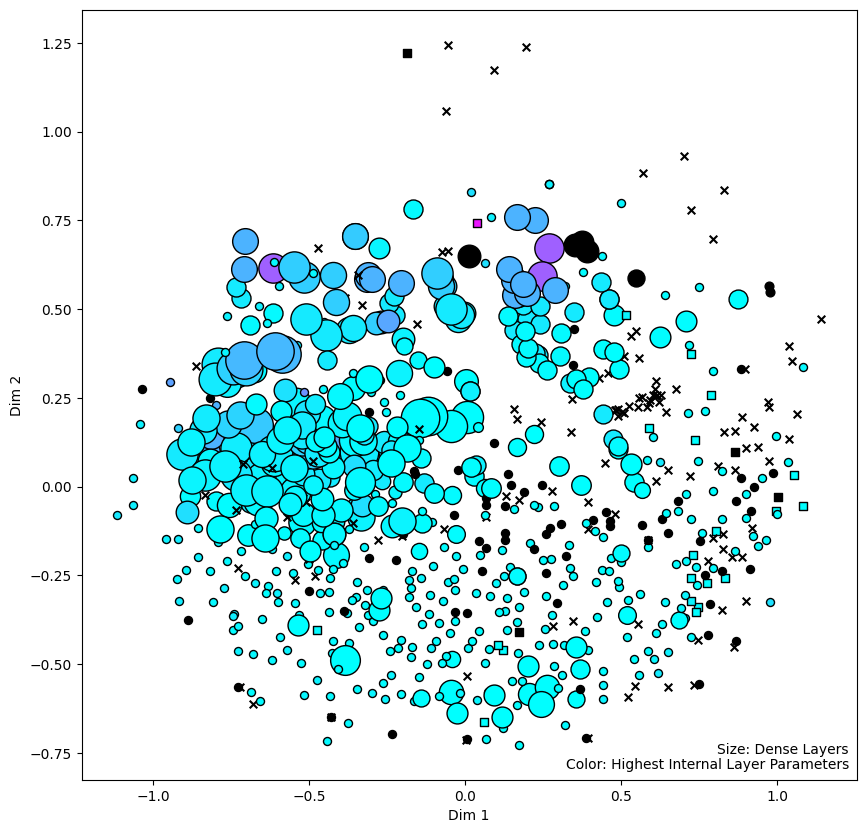

In [6]:
plot_all_mds(
    groupCoordinates,
    modelInfo,
    modelNames,
    dimCols=["Dense Layers", "Highest Internal Layer Parameters"],
    showName=False,
)

In [7]:
groupCoordinates = indscalResults[1]["gspace"]
_ = show_best_dim_cors(groupCoordinates, modelInfo, modelNames)

Dimension 1
Only have 153 values for Residual Blocks and dim 0
Only have 197 values for Bottlenecks and dim 0
Only have 239 values for Pooling Layers and dim 0
Only have 0 values for Recurrent Layers and dim 0
Only have 236 values for Attention Layers and dim 0
Sorted correlations:
Layers: 0.2986317309037815
Dense Layers: 0.2711075854059408
Highest Internal Layer Parameters: 0.14045901452973292
Parameters: 0.13913154774410466
Normalization Layers: 0.12193635273019325
Last Layer Parameters: 0.10882561008080041
Conv Layers: 0.10787703367769559
Output Features: 0.1018472196978126
First Layer Parameters: 0.08925651671037955
Lowest Internal Layer Parameters: 0.0018834002247900717
==
Dimension 2
Only have 153 values for Residual Blocks and dim 1
Only have 197 values for Bottlenecks and dim 1
Only have 239 values for Pooling Layers and dim 1
Only have 0 values for Recurrent Layers and dim 1
Only have 236 values for Attention Layers and dim 1
Sorted correlations:
Dense Layers: 0.59041324368444

/tmp/ipykernel_970482/3086515401.py:133: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, s=size, marker=marker, color=color, alpha=1, edgecolor="black")


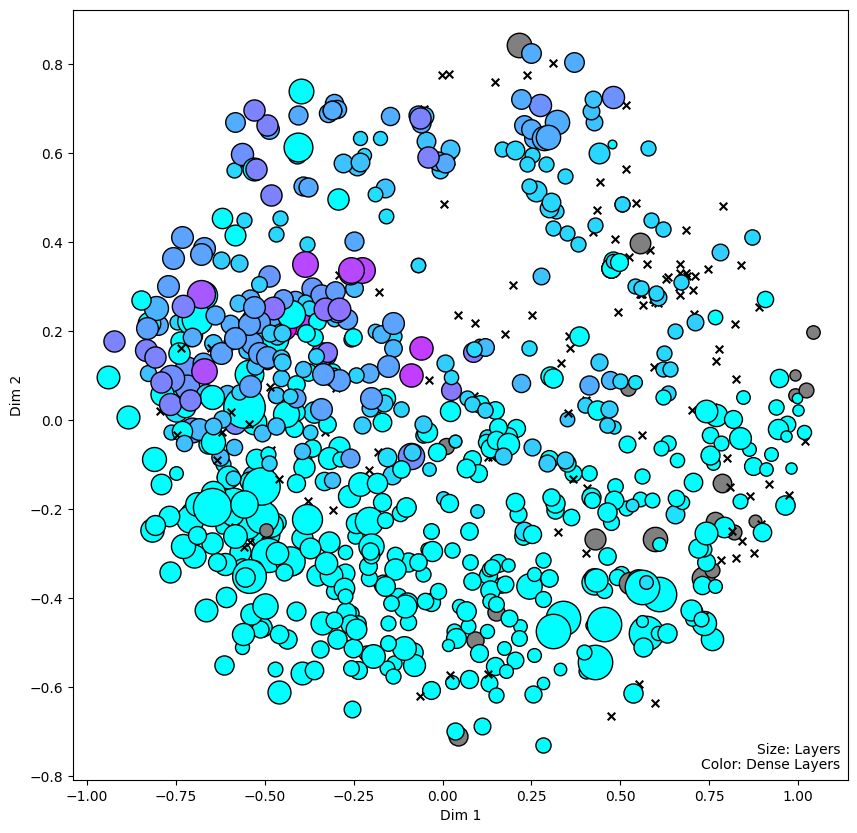

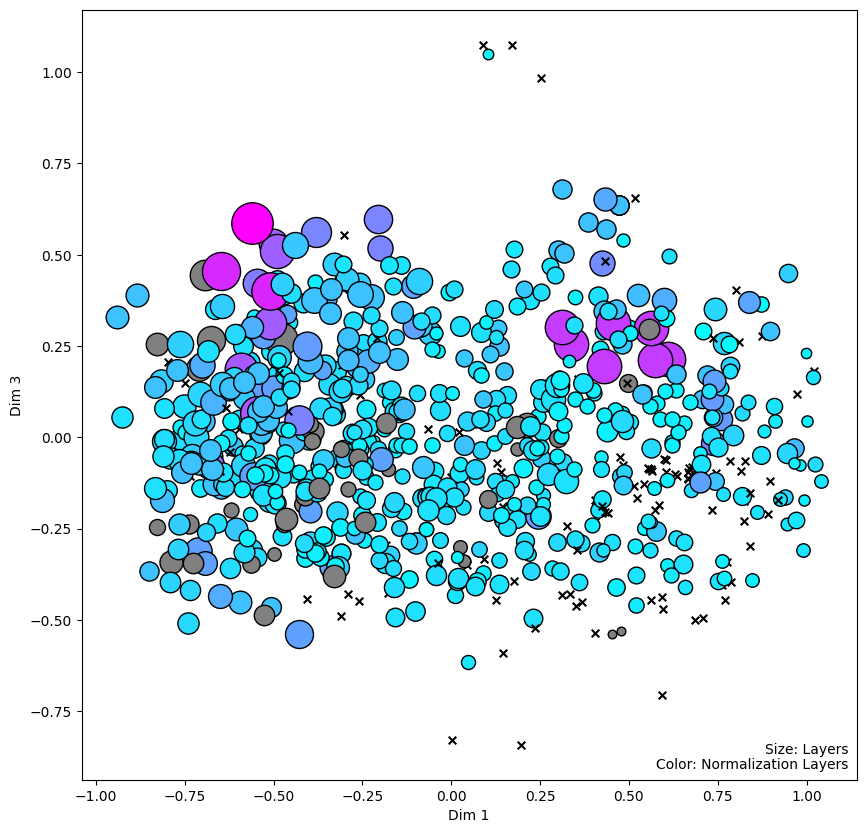

In [8]:
plot_all_mds(
    groupCoordinates,
    modelInfo,
    modelNames,
    dimCols=["Layers", "Dense Layers", "Normalization Layers"],
    showName=False,
)

In [9]:
groupCoordinates = indscalResults[2]["gspace"]
_ = show_best_dim_cors(groupCoordinates, modelInfo, modelNames)

Dimension 1
Only have 153 values for Residual Blocks and dim 0
Only have 197 values for Bottlenecks and dim 0
Only have 239 values for Pooling Layers and dim 0
Only have 0 values for Recurrent Layers and dim 0
Only have 236 values for Attention Layers and dim 0
Sorted correlations:
Dense Layers: 0.3413408594413627
Layers: 0.20967254814594985
First Layer Parameters: 0.12603571407774675
Last Layer Parameters: 0.11955666061403614
Highest Internal Layer Parameters: 0.11539916745024703
Parameters: 0.10667404009784183
Output Features: 0.0887132247636956
Normalization Layers: 0.016718848145143936
Lowest Internal Layer Parameters: 0.01212292165536038
Conv Layers: 0.004247343646682571
==
Dimension 2
Only have 153 values for Residual Blocks and dim 1
Only have 197 values for Bottlenecks and dim 1
Only have 239 values for Pooling Layers and dim 1
Only have 0 values for Recurrent Layers and dim 1
Only have 236 values for Attention Layers and dim 1
Sorted correlations:
Dense Layers: 0.5596308080347

/tmp/ipykernel_970482/3086515401.py:133: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, s=size, marker=marker, color=color, alpha=1, edgecolor="black")


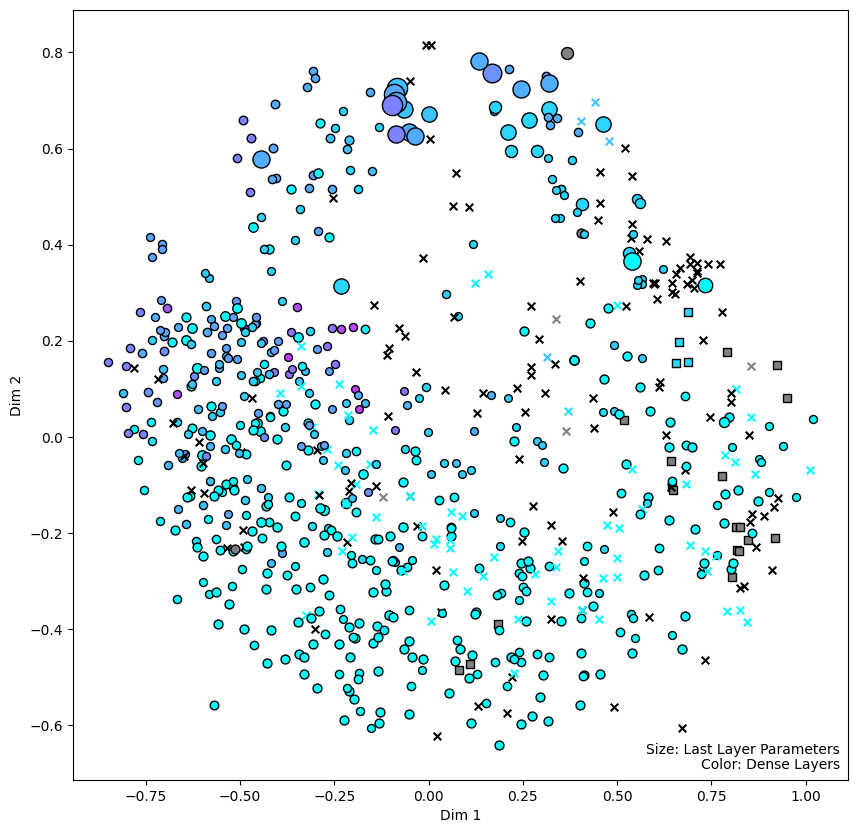

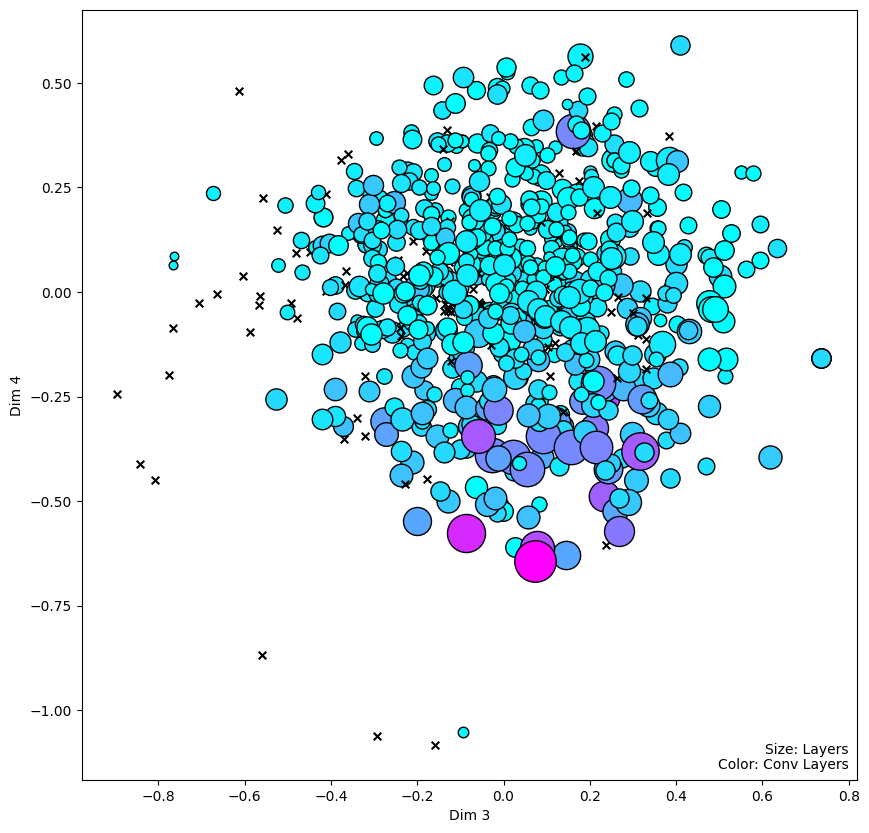

In [10]:
plot_all_mds(
    groupCoordinates,
    modelInfo,
    modelNames,
    dimCols=["Last Layer Parameters", "Dense Layers", "Layers", "Conv Layers"],
    showName=False,
)

In [11]:
nDims = indscalResults[2]["cweights"].shape[0]
datasetNames = list(datasets._DATA_DIRS.keys())

dimWeights = []
for i in range(nDims):
    weights = indscalResults[2]["cweights"][i, i, :]
    dimWeights += [weights]

    for j, dataset in enumerate(datasetNames):
        print(f"Dim {i+1}, {dataset}: {weights[j]}")

    print("==")
dimWeights = np.stack(dimWeights, axis=0)

dimWeights

Dim 1, fribbles: 0.6941720015782724
Dim 1, greebles: 0.6373675981453496
Dim 1, yufos: 0.7262267333646694
Dim 1, ziggerins: 0.6757579012049467
Dim 1, ecoset: 0.914390979126353
Dim 1, CUB200: 0.7493082641821598
Dim 1, cars196: 0.7970914001590885
Dim 1, kiani: 0.9316713958678139
Dim 1, VGGFace: 0.8456806523676499
==
Dim 2, fribbles: 0.7464367694247573
Dim 2, greebles: 0.8278396095645372
Dim 2, yufos: 1.032693909858894
Dim 2, ziggerins: 0.9532078272954763
Dim 2, ecoset: 1.0798397696981223
Dim 2, CUB200: 1.1894888201962193
Dim 2, cars196: 1.0317192772506776
Dim 2, kiani: 1.0028679849138553
Dim 2, VGGFace: 1.101259352347426
==
Dim 3, fribbles: 1.3712556218025138
Dim 3, greebles: 1.2405919781991819
Dim 3, yufos: 1.2874014377217695
Dim 3, ziggerins: 1.4211755975553244
Dim 3, ecoset: 1.1823897135060137
Dim 3, CUB200: 1.3824866035020391
Dim 3, cars196: 1.4989728623941083
Dim 3, kiani: 1.2035889268392022
Dim 3, VGGFace: 1.2686533801425783
==
Dim 4, fribbles: 1.703888317245379
Dim 4, greebles: 1.8

array([[0.694172  , 0.6373676 , 0.72622673, 0.6757579 , 0.91439098,
        0.74930826, 0.7970914 , 0.9316714 , 0.84568065],
       [0.74643677, 0.82783961, 1.03269391, 0.95320783, 1.07983977,
        1.18948882, 1.03171928, 1.00286798, 1.10125935],
       [1.37125562, 1.24059198, 1.28740144, 1.4211756 , 1.18238971,
        1.3824866 , 1.49897286, 1.20358893, 1.26865338],
       [1.70388832, 1.8060104 , 1.41666647, 1.51061153, 1.08172376,
        1.10793704, 1.1086259 , 1.15025721, 1.18829385]])

In [12]:
groupCoordinates = indscalResults[3]["gspace"]
_ = show_best_dim_cors(groupCoordinates, modelInfo, modelNames)

Dimension 1
Only have 153 values for Residual Blocks and dim 0
Only have 197 values for Bottlenecks and dim 0
Only have 239 values for Pooling Layers and dim 0
Only have 0 values for Recurrent Layers and dim 0
Only have 236 values for Attention Layers and dim 0
Sorted correlations:
Dense Layers: 0.2871114106316016
Layers: 0.19929489593306732
First Layer Parameters: 0.12816892653459405
Last Layer Parameters: 0.11471129537745672
Output Features: 0.09770528233488356
Highest Internal Layer Parameters: 0.08314864103982178
Parameters: 0.07461395594175142
Normalization Layers: 0.029348601211322423
Conv Layers: 0.022023379096320926
Lowest Internal Layer Parameters: 0.010318674014252512
==
Dimension 2
Only have 153 values for Residual Blocks and dim 1
Only have 197 values for Bottlenecks and dim 1
Only have 239 values for Pooling Layers and dim 1
Only have 0 values for Recurrent Layers and dim 1
Only have 236 values for Attention Layers and dim 1
Sorted correlations:
Dense Layers: 0.55158514838

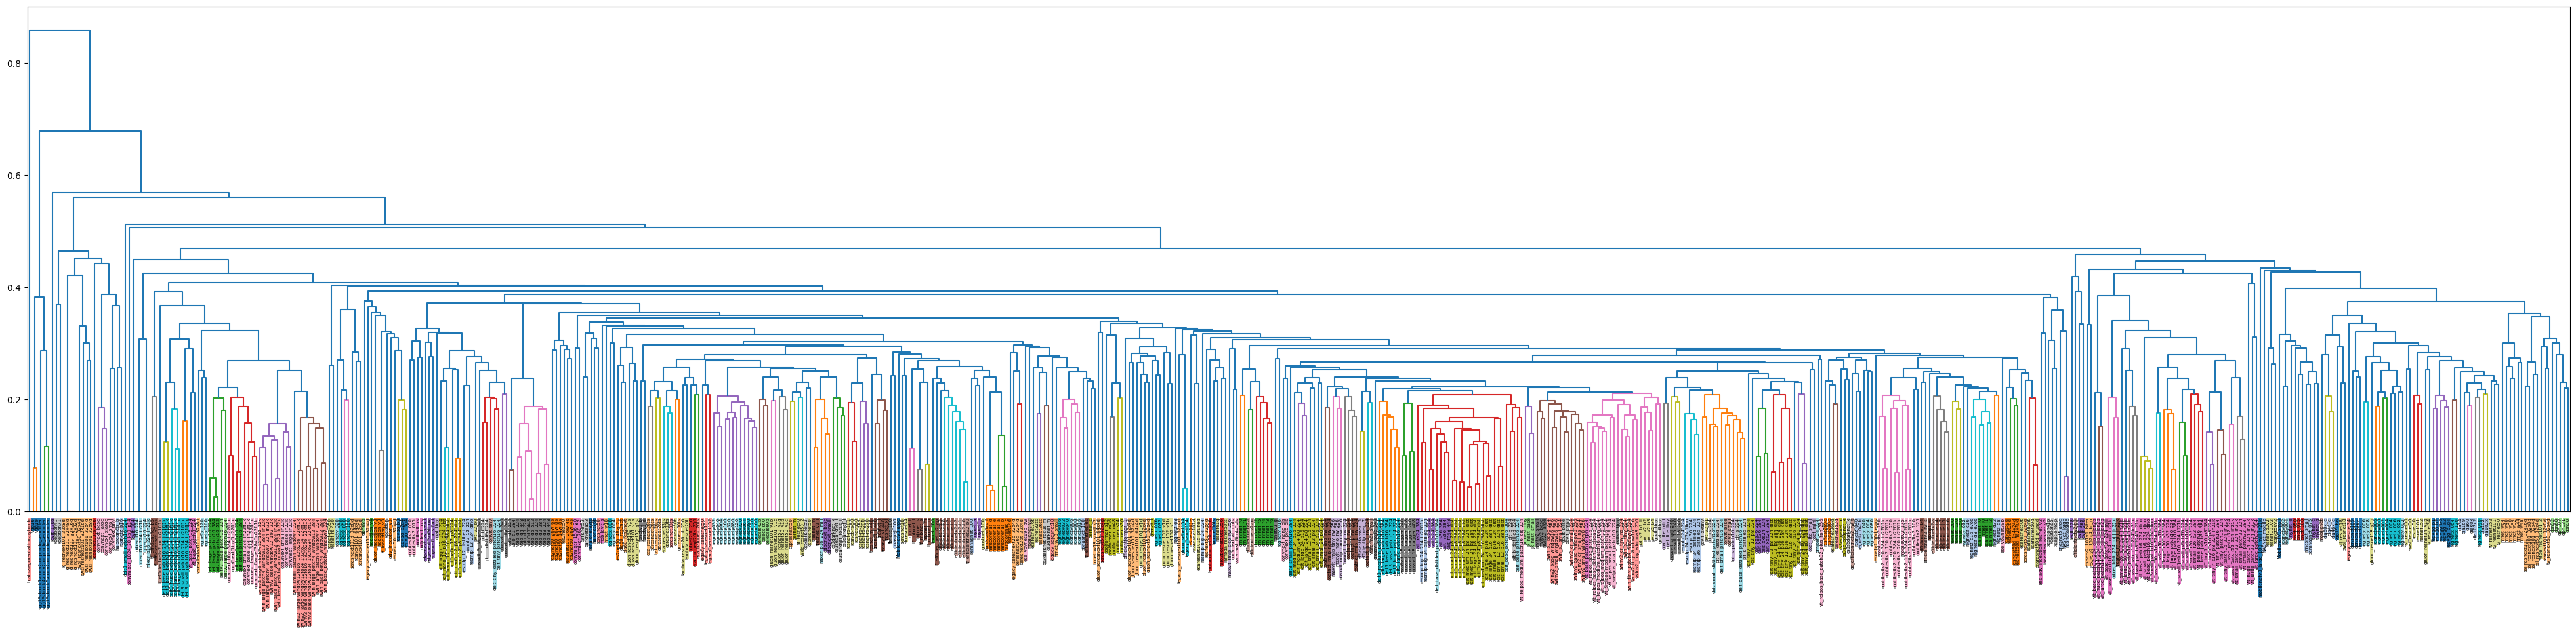

In [142]:
# Load all sims
simFiles = os.listdir("../data_storage/sims")
simFiles = sorted(simFiles)

# Load the first dataset to get info
simMat = pd.read_csv(f"../data_storage/sims/{simFiles[0]}", index_col=0)

modelNames = list(simMat.columns)

# Turn simMat into an array
simMat = simMat.values

# Loop through the rest
for file in simFiles[1:]:
    # Load the simMat
    tmp = pd.read_csv(f"../data_storage/sims/{file}", index_col=0)

    # Make sure the columns are in the same order
    tmp = tmp[modelNames]

    # Make sure the rows are in the same order
    tmp = tmp.loc[modelNames]

    # Add to simMat
    simMat += tmp.values

simMat = simMat / len(simFiles)
distMat = 1 - simMat
distMat[distMat < 0] = 0

categoricalCols = [
    "has Convolutional Layers",
    "has Residual Blocks",
    "has Dense Layers",
    "has Bottlenecks",
    "has Recurrent Layers",
    "has Skip Connections",
    "has Attention Layers",
    "Tokenized",
    "Transformer",
    "has ReLU",
    "has GeLU",
    "Pooling Type",
]

# Make a new column combining a few interesting columns
comboCols = [
    "has Dense Layers",
    "has Bottlenecks",
    "has Residual Blocks",
    "has Attention Layers",
    "has GeLU",
]
modelInfo["Combo"] = modelInfo[comboCols].apply(
    lambda x: "-".join(x.astype(str)), axis=1
)

categoricalCols += ["Combo"]

# Make sure modelInfo has the same order as modelNames
clusterModelInfo = modelInfo.loc[modelInfo["Model"].isin(modelNames)]
clusterModelInfo = clusterModelInfo.drop_duplicates(subset="Model")
clusterModelNames = clusterModelInfo["Model"].values

# Find the models not in clusterModelInfo
missingModels = [model for model in modelNames if model not in clusterModelNames]

# Remove these models from the distance matrix
missingIdx = [modelNames.index(model) for model in missingModels]
distMat = np.delete(distMat, missingIdx, axis=0)
distMat = np.delete(distMat, missingIdx, axis=1)
modelNames = [model for model in modelNames if model in clusterModelNames]

# Only keep rows in modelNames
clusterModelInfo = clusterModelInfo.loc[clusterModelInfo["Model"].isin(modelNames)]

# Reorder the rows to match modelNames
clusterModelInfo = clusterModelInfo.set_index("Model").loc[modelNames]

clusters = linkage(squareform(distMat), method="average")

In [98]:
distRange = np.linspace(0.1, 0.4, 50)
for col in categoricalCols:
    print(f"== {col} ==")
    scores = []
    for t in distRange:
        flatClusters = fcluster(clusters, t=t, criterion="distance")
        score = adjusted_rand_score(clusterModelInfo[col], flatClusters)
        scores.append(score)

        print(f"t = {t}, score = {score}")

    # Get the highest score and its corresponding t
    bestScore = max(scores)
    bestIdx = scores.index(bestScore)
    print(f"Best score: t = {distRange[bestIdx]}, score = {bestScore}")

# Also do "Family" column
scores = []
print("== Family ==")
for t in distRange:
    flatClusters = fcluster(clusters, t=t, criterion="distance")
    score = adjusted_rand_score(clusterModelInfo["Family"], flatClusters)
    scores.append(score)

    print(f"t = {t}, score = {score}")

# Get the highest score and its corresponding t
bestScore = max(scores)
bestIdx = scores.index(bestScore)
print(f"Best score: t = {distRange[bestIdx]}, score = {bestScore}")

== has Convolutional Layers ==
t = 0.1, score = 0.0004675682014443162
t = 0.10612244897959185, score = 0.0004963439018769705
t = 0.11224489795918369, score = 0.000532313897990176
t = 0.11836734693877551, score = 0.0005754784368415237
t = 0.12448979591836735, score = 0.0006761980000506619
t = 0.1306122448979592, score = 0.0007913100254057144
t = 0.13673469387755102, score = 0.0008776468117362772
t = 0.14285714285714285, score = 0.0009999613196218925
t = 0.1489795918367347, score = 0.0014173054728942882
t = 0.15510204081632656, score = 0.0015252483264090175
t = 0.16122448979591839, score = 0.0020196526833760643
t = 0.1673469387755102, score = 0.0022192579239801572
t = 0.17346938775510207, score = 0.0027628596484523815
t = 0.1795918367346939, score = 0.0032047169687841816
t = 0.18571428571428572, score = 0.0031095101457258127
t = 0.19183673469387758, score = 0.0036533799008153325
t = 0.1979591836734694, score = 0.00427290580086099
t = 0.20408163265306123, score = 0.004232303836539279
t = 

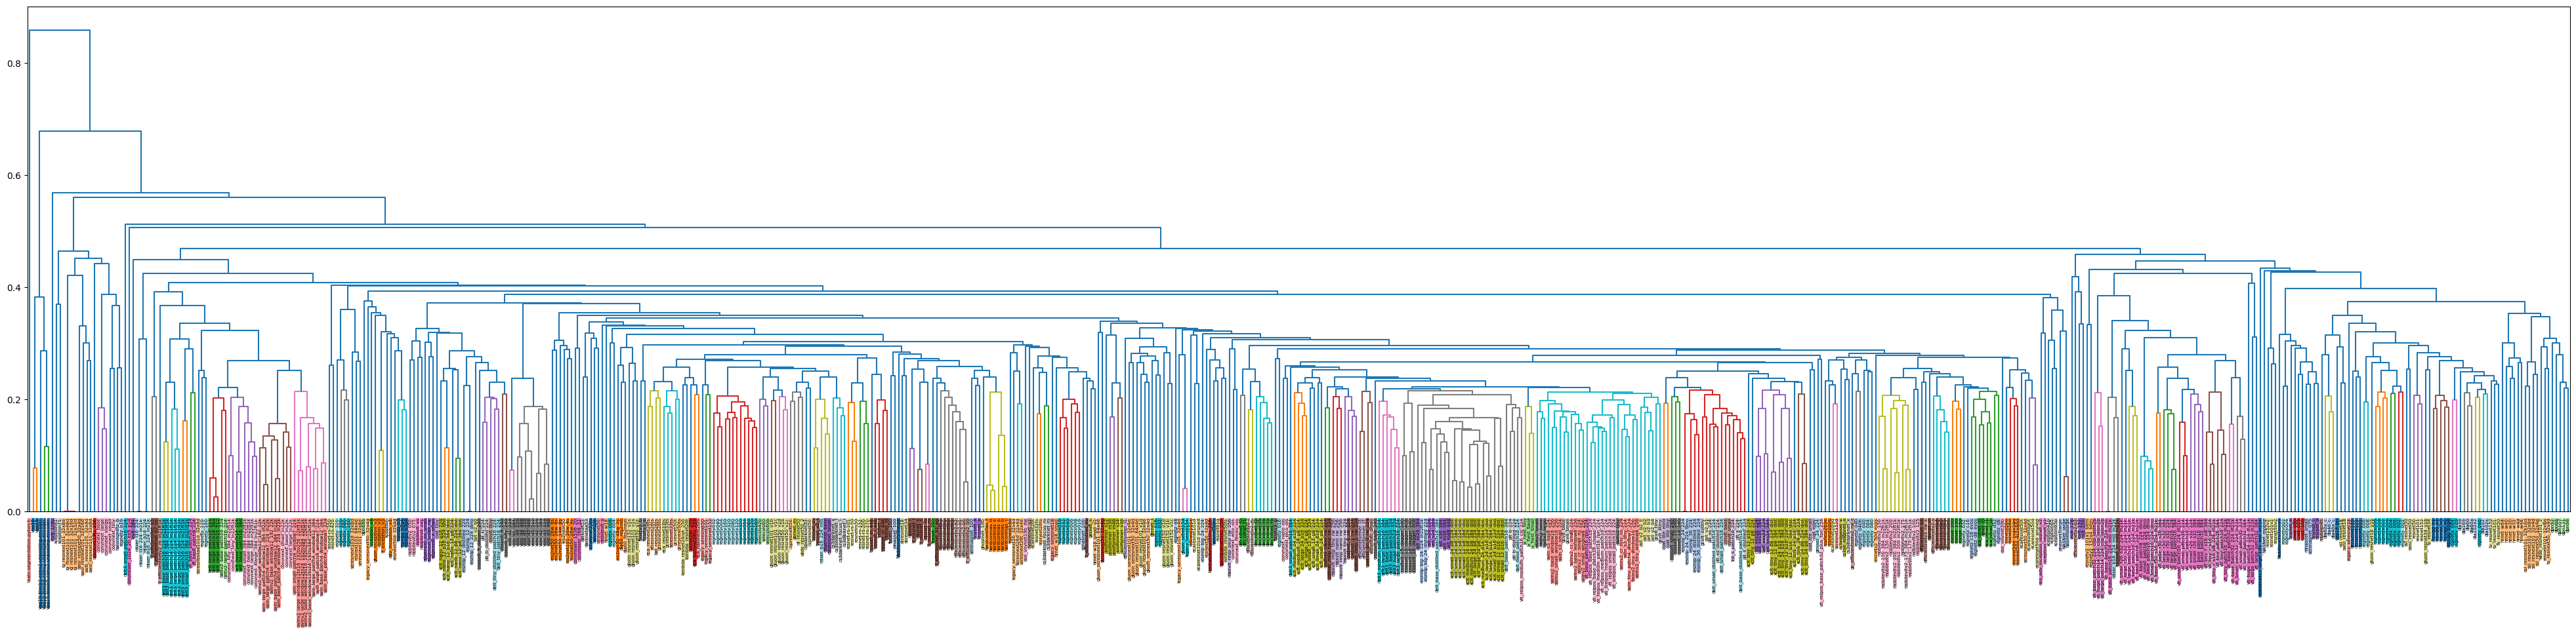

In [149]:
fig, ax = plt.subplots(1, 1, figsize=(50, 10))
_ = dendrogram(
    clusters,
    # truncate_mode="distance",
    # p=15,
    color_threshold=0.2163265306122449,
    labels=clusterModelInfo.index,
    leaf_font_size=5,
    distance_sort=True,
    ax=ax,
)

# Color the background of the labels based on the family
tab20 = matplotlib.cm.tab20
familyColors = {
    family: tab20(i % 20)
    for i, family in enumerate(clusterModelInfo["Family"].unique())
}

for i, label in enumerate(ax.get_xticklabels()):
    model = label.get_text()
    family = clusterModelInfo.loc[model, "Family"]
    label.set_bbox(
        dict(pad=-0.5, facecolor=familyColors[family], edgecolor=("black", 0))
    )


# Save fig
fig.savefig("dendrogramFamily.png", dpi=300, bbox_inches="tight")

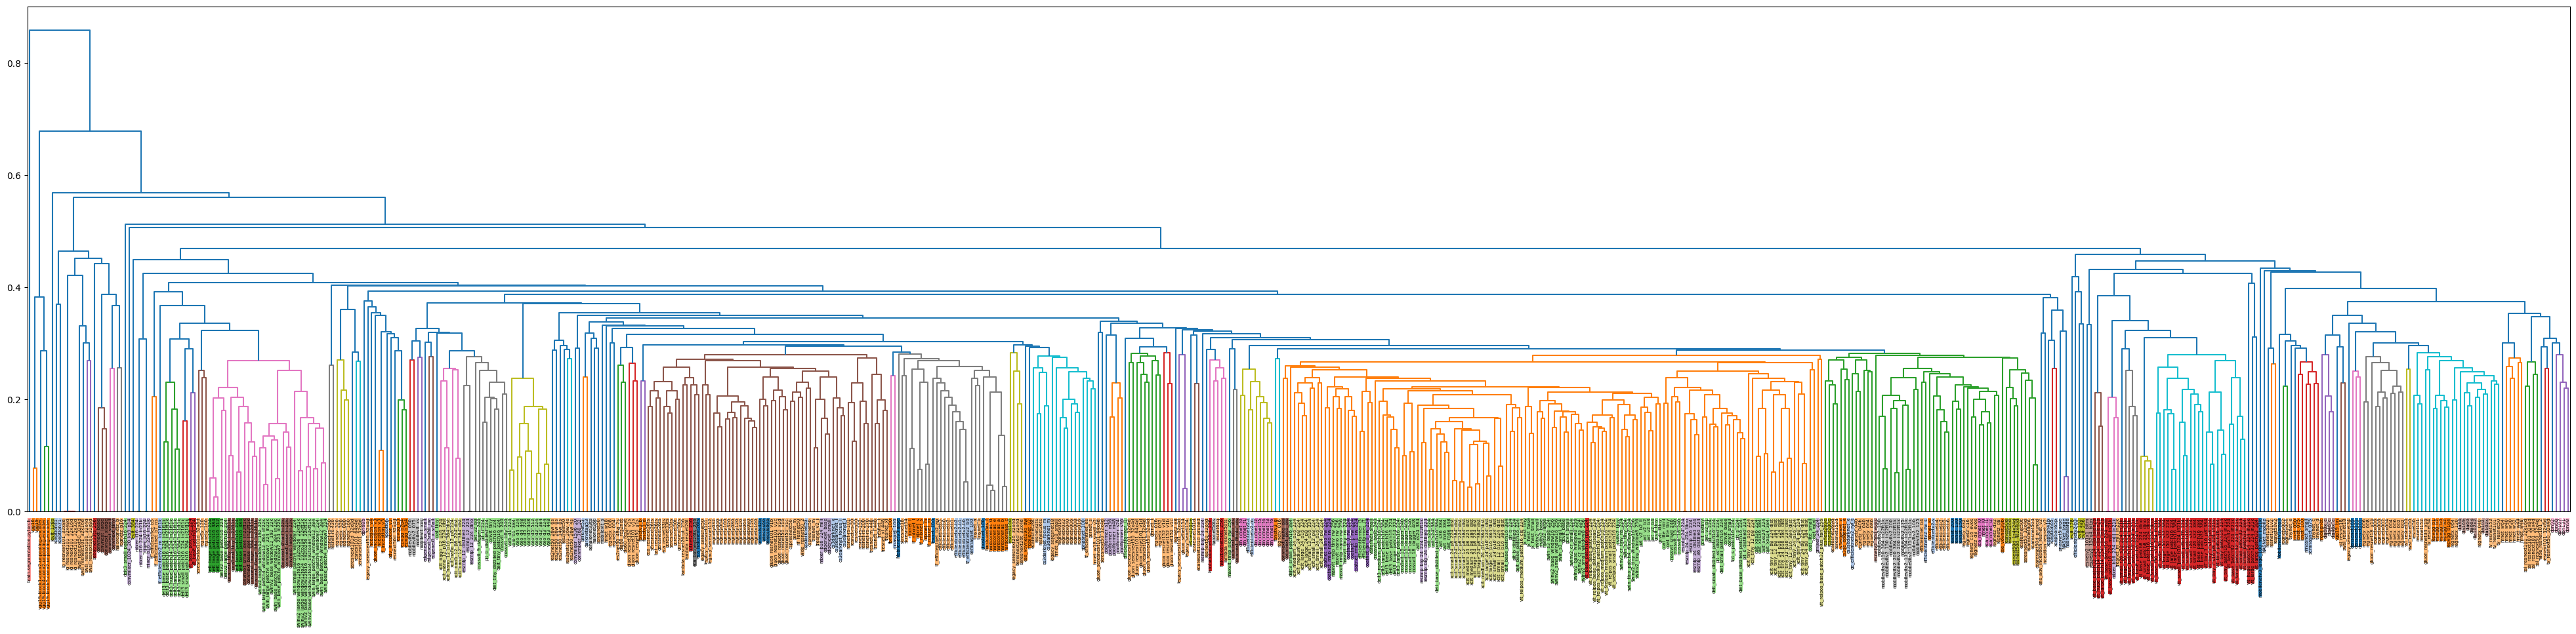

In [148]:
fig, ax = plt.subplots(1, 1, figsize=(50, 10))
_ = dendrogram(
    clusters,
    # truncate_mode="distance",
    # p=15,
    color_threshold=0.2836734693877551,
    labels=clusterModelInfo.index,
    leaf_font_size=5,
    distance_sort=True,
    ax=ax,
)

# Color the background of the labels based on the Combo
tab20 = matplotlib.cm.tab20
comboColors = {
    combo: tab20(i % 20) for i, combo in enumerate(clusterModelInfo["Combo"].unique())
}

for i, label in enumerate(ax.get_xticklabels()):
    model = label.get_text()
    combo = clusterModelInfo.loc[model, "Combo"]
    label.set_bbox(dict(pad=-0.5, facecolor=comboColors[combo], edgecolor=("black", 0)))


# Save fig
fig.savefig("dendrogramCombo.png", dpi=300, bbox_inches="tight")

# Trained Models


In [79]:
# Load trainedSims.csv
trainedSims = pd.read_csv("../data_storage/trainedSims.csv", index_col=0)

# Remove .npy at the end of rows/columns
trainedSims.index = trainedSims.index.str.replace(".npy", "")
trainedSims.columns = trainedSims.columns.str.replace(".npy", "")

# Nat sort the columns
sortedCols = natsort.natsorted(trainedSims.columns)
trainedSims = trainedSims.reindex(sortedCols, axis=1)
trainedSims = trainedSims.reindex(sortedCols)

# Turn into a distance matrix
trainedDist = 1 - trainedSims.values
trainedDist[trainedDist < 0] = 0

In [80]:
# Load all the model training info
trainLogFiles = os.listdir("../data_storage/models")
trainLogFiles = [file for file in trainLogFiles if file.endswith(".csv")]
trainLogFiles = natsort.natsorted(trainLogFiles)

# Loop through all logFiles and save last epoch info
trainLog = pd.DataFrame()
for file in trainLogFiles:
    tmp = pd.read_csv(f"../data_storage/models/{file}")
    tmp = tmp.iloc[-1][["val_accuracy", "val_loss"]]

    # Get model name and info
    modelName = file.replace(".csv", "")
    dense, conv = file.split("_")[1:3]
    dense = int(dense.replace("dense", ""))
    conv = int(conv.replace("conv", ""))

    # Add name, dense, and conv to tmp
    tmp["dense"] = dense
    tmp["conv"] = conv
    tmp["model"] = modelName

    # Concatenate row to trainLog
    trainLog = pd.concat([trainLog, tmp.to_frame().T])

trainLog

,val_accuracy,val_loss,dense,conv,model
349,0.8643,0.444952,1.0,2.0,cnn00_dense1_conv2_augment
349,0.8741,0.443346,1.0,3.0,cnn00_dense1_conv3_augment
349,0.8845,0.425121,1.0,4.0,cnn00_dense1_conv4_augment
349,0.8845,0.46849,1.0,5.0,cnn00_dense1_conv5_augment
349,0.8918,0.474676,1.0,6.0,cnn00_dense1_conv6_augment
...,...,...,...,...,...
349,0.1651,2.21053,10.0,7.0,cnn00_dense10_conv7_augment
349,0.1,2.302583,10.0,8.0,cnn00_dense10_conv8_augment
349,0.4547,1.559681,10.0,9.0,cnn00_dense10_conv9_augment
349,0.1,2.302583,10.0,10.0,cnn00_dense10_conv10_augment


In [96]:
# Get list of models with accuracy near 0.1
badModels = trainLog.loc[trainLog["val_accuracy"] < 0.12]
print(len(badModels))
badModels

52


,val_accuracy,val_loss,dense,conv,model
349,0.1,2.302583,1.0,8.0,cnn00_dense1_conv8_augment
349,0.1,2.302583,1.0,9.0,cnn00_dense1_conv9_augment
349,0.1,2.302583,1.0,10.0,cnn00_dense1_conv10_augment
349,0.1,2.302583,1.0,11.0,cnn00_dense1_conv11_augment
349,0.1,2.302583,2.0,11.0,cnn00_dense2_conv11_augment
349,0.1,2.302583,3.0,7.0,cnn00_dense3_conv7_augment
349,0.1,2.302583,3.0,10.0,cnn00_dense3_conv10_augment
349,0.1,2.302583,4.0,6.0,cnn00_dense4_conv6_augment
349,0.1,2.302583,4.0,7.0,cnn00_dense4_conv7_augment
349,0.1,2.302583,4.0,9.0,cnn00_dense4_conv9_augment


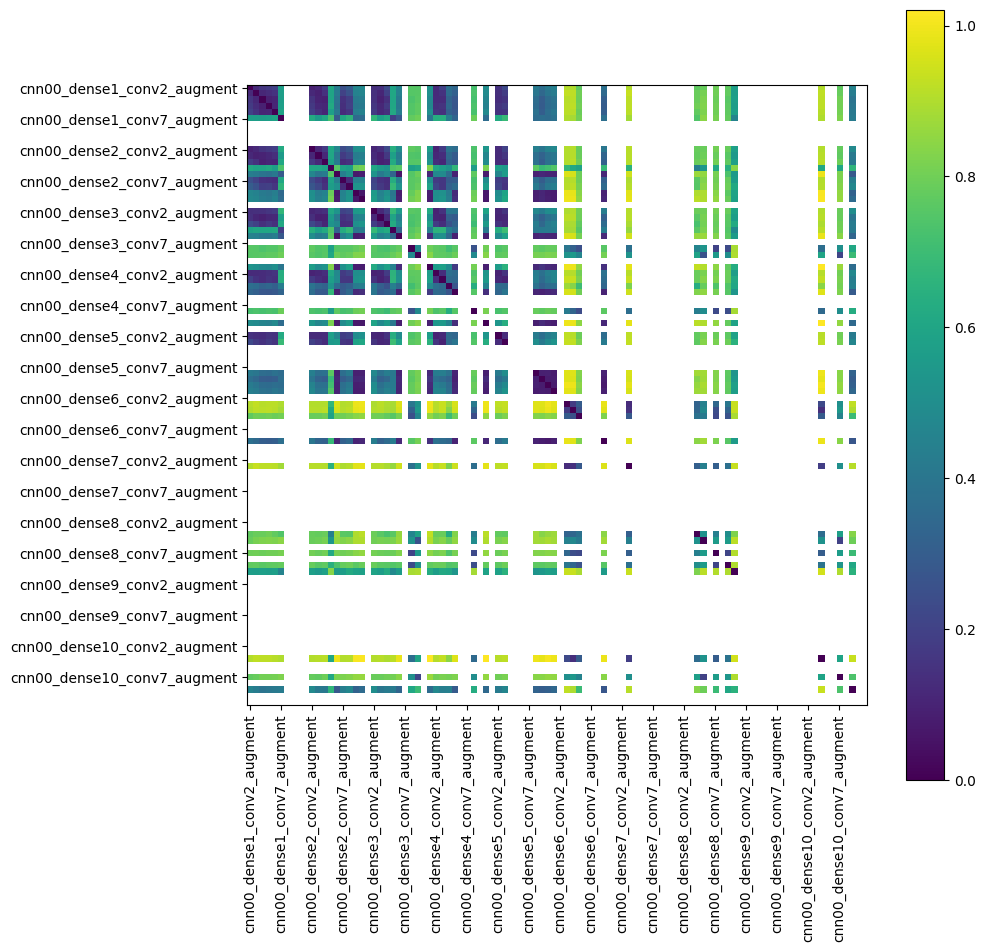

In [82]:
# Draw a heatmap
heatmap = np.copy(trainedDist)

# Make heatmap columns and rows NA for bad models
for model in badModels["model"]:
    idx = trainedSims.columns.get_loc(model)
    heatmap[:, idx] = np.nan
    heatmap[idx, :] = np.nan

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

cax = ax.matshow(heatmap, cmap="viridis")

# Add colorbar
fig.colorbar(cax)

# Add a tick for every 5 model
everyFive = np.arange(trainedSims.shape[1], step=5)
_ = ax.set_xticks(everyFive)
_ = ax.set_yticks(everyFive)

# Move x axis ticks to bottom
_ = ax.xaxis.set_ticks_position("bottom")

# Add labels to ticks
_ = ax.set_xticklabels(trainedSims.columns[everyFive], rotation=90)
_ = ax.set_yticklabels(trainedSims.columns[everyFive])

In [83]:
# Remove bad models from trainedSims
trainedSims = trainedSims.drop(badModels["model"], axis=0)
trainedSims = trainedSims.drop(badModels["model"], axis=1)

# Remove bad models from trainedDist
trainedDist = 1 - trainedSims.values

# Calculate MDS
mds = MDS(n_components=2, dissimilarity="precomputed")
mdsCoordinates = mds.fit_transform(trainedDist)

Text(0.99, 0.03, 'Size: Dense')

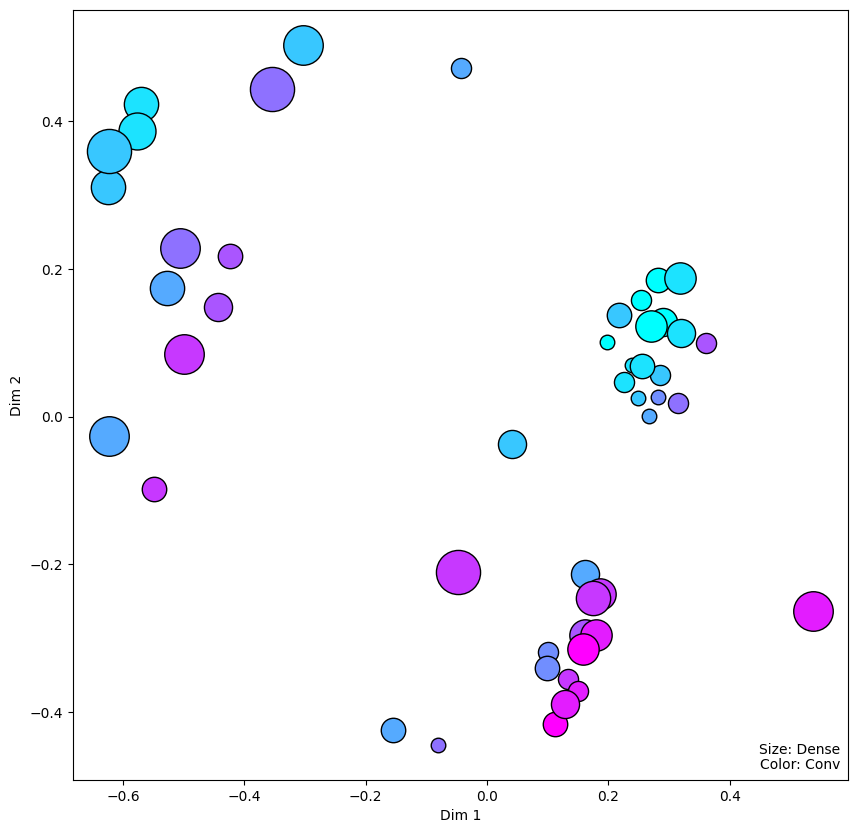

In [95]:
# Plot MDS
colorNorm = matplotlib.colors.Normalize(
    vmin=trainLog["conv"].min(), vmax=trainLog["conv"].max()
)
colorMapper = matplotlib.cm.ScalarMappable(norm=colorNorm, cmap=matplotlib.cm.cool)

# Plot MDS
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

densePars = np.array([])
convPars = np.array([])
for i, model in enumerate(trainedSims.columns):
    x = mdsCoordinates[i, 0]
    y = mdsCoordinates[i, 1]

    # Find the row in trainLog
    row = trainLog[trainLog["model"] == model]
    if row["val_accuracy"].values[0] < 0.12:
        # Make the marker an x
        size = 10
        marker = "x"
        color = "black"
    else:
        size = 10 + 100 * row["dense"].values[0]
        marker = "o"
        color = colorMapper.to_rgba(row["conv"].values[0])

        # Add dense and conv aprs
        densePars = np.append(densePars, row["dense"].values[0])
        convPars = np.append(convPars, row["conv"].values[0])

    ax.scatter(x, y, s=size, marker=marker, color=color, alpha=1, edgecolor="black")


# Label axes
ax.set_xlabel("Dim 1")
ax.set_ylabel("Dim 2")

# Add annotation for color and size
ax.text(
    0.99,
    0.01,
    "Color: Conv",
    verticalalignment="bottom",
    horizontalalignment="right",
    transform=ax.transAxes,
)
ax.text(
    0.99,
    0.03,
    "Size: Dense",
    verticalalignment="bottom",
    horizontalalignment="right",
    transform=ax.transAxes,
)

In [93]:
# Correlate MDS coordinates with dense and conv
print("Correlation between MDS coordinates and dense:")
print(np.corrcoef(mdsCoordinates[:, 0], densePars)[0, 1])
print(np.corrcoef(mdsCoordinates[:, 1], densePars)[0, 1])

print("Correlation between MDS coordinates and conv:")
print(np.corrcoef(mdsCoordinates[:, 0], convPars)[0, 1])
print(np.corrcoef(mdsCoordinates[:, 1], convPars)[0, 1])

Correlation between MDS coordinates and dense:
-0.5385199703891116
0.279230191603182
Correlation between MDS coordinates and conv:
-0.026318238364429238
-0.6003210975486448
